In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
sys.path.append('..')
from utilsFunc import NS_Distribution as nsd
from utilsFunc import utils as ut

In [33]:
p = r"..\data\BAGOTVILLE A.csv"
#Vitesse de vent (m/s)
BG_data = (pd.read_csv(p, index_col=0)
           .assign(Time = lambda x: x['Time (LST)'])
           .assign(Date = lambda x: ut.get_date_time(x))
           .rename(columns={"Wind Spd (km/h)": "WS"})
)


p = r"..\data\fremantle.csv"
#Donnée de niveau de la mer (m) de Fremantle
FM_data = (pd.read_csv(p, index_col=0, parse_dates=True)
           .assign(Year_  = lambda x: (x.Year - x.Year.min() + 1))
           .assign(Year_2 = lambda x: x.Year_**2))

p = r"..\data\nao.data.txt"
nao = ut.load_climate_index(p)

In [3]:
BG_data_nao = (BG_data.set_index('Date')
           .drop(columns=['Year', 'Month', 'Day', 'Time (LST)'])
           .sort_index()
           .resample('YS').mean() 

 #Creer une colonne avec la date décallé de 10 mois
 .reset_index().assign(shift_M = lambda x: pd.DatetimeIndex(pd.DatetimeIndex(x.Date).shift(-1, freq = 'Y')).shift(-10, freq = 'MS'))
 .assign(shift_M = lambda x: ut.get_date_Month(x.shift_M))
 .set_index('Date')
 #Merger la série avec les données de NAO
.merge(nao, left_index=True, right_index=True)
.rename(columns={'value':'nao'})
)

min_exclude_zero = BG_data_nao.WS.replace(0, np.nan).min()

BG_data_nao = (BG_data_nao.assign(Year = lambda x: x.index.year)
           .assign(Year_std  = lambda x: (x.Year - x.Year.min() + 1))
           .assign(nao = lambda x: (x.nao - x.nao.mean())/x.nao.std()))


In [31]:
import itertools
covar = ['nao', None, 'Year_std']
options = list(itertools.product(covar, covar)) #Cartesian product of the covar list

res = []
for opt in options:
  
  sgP = opt[0]
  bP = opt[1]


  _res_aic = {}
  _res_coeff = {}

  _res = nsd.W2_NS_fit(BG_data_nao.WS, covar= BG_data_nao, shape_var = [bP], scale_var = [sgP])
  _res_aic[tuple(opt)] = _res[1]
  _res_coeff[tuple(opt)] = _res[0]
  res.append((_res_aic, _res_coeff))

In [32]:
def get_NonStatfit_results(res):
    results = pd.concat([pd.DataFrame(res[i][0])
                         .T.merge(pd.DataFrame(res[i][1]).T, 
                                  left_index=True, right_index=True) 
                                  for i in range(len(res))], axis=0)
    
    return results
get_NonStatfit_results(res)

aic        a0        a1         b0        b1
nao      nao       88.325369  4.433790 -0.100171  10.996198 -1.023552
         NaN       87.345561  4.432906 -0.093465  10.888452       NaN
         Year_std  76.709301  4.344222 -0.053581   6.235176  0.187291
NaN      nao       90.108228  4.450021       NaN  10.729257 -0.647974
         NaN       88.528292  4.438046       NaN  10.706842       NaN
         Year_std  75.941857  4.327906       NaN   5.705325  0.202192
Year_std nao       71.348217  4.754884 -0.009305  13.019880 -1.996750
         NaN       71.769739  4.724781 -0.008557  12.826996       NaN
         Year_std  71.853526  4.639963 -0.006513   9.638258  0.099016

In [35]:
FM_data

,Year,SeaLevel,SOI,Year_,Year_2
1,1897,1.58,-0.67,1,1
2,1898,1.71,0.57,2,4
3,1899,1.40,0.16,3,9
4,1900,1.34,-0.65,4,16
5,1901,1.43,0.06,5,25
...,...,...,...,...,...
89,1985,1.57,-0.07,89,7921
90,1986,1.56,-0.32,90,8100
91,1987,1.46,-1.47,91,8281
92,1988,1.70,0.73,92,8464


In [39]:
from scipy.stats import genextreme as GEV

#Ajuster une loi GEV non stationnaire
res = nsd.GEV_NS_fit(FM_data.SeaLevel, mu_var=['SOI', 'Year_'], covar=FM_data)

#échantillon de SOI 
SOI = FM_data.SOI.sample(10)
Year_ = 100
param = res[0]

#mu = mu0 + mu1*SOI + mu2*Year_
#Calcul d'un quantile à partir des résultats
mu = param['mu0'] + param['mu1']*SOI + param['mu2']*Year_


sigma0 = param['sigma0']
k0= param['k0']
Q = GEV.isf(0.01, c=k0, loc=mu, scale=sigma0)
  

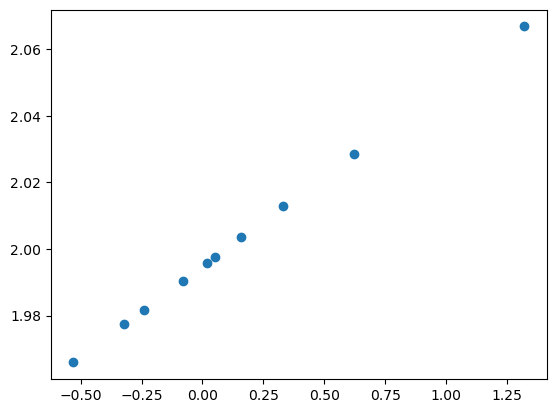

In [41]:
plt.plot(SOI, Q, 'o')